In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
sys.executable

'/home/joz608/.conda/envs/jupyter_launcher/bin/python3.8'

In [3]:
import sys
import os
import copy
import pathlib
import time
import gc

from tqdm import tqdm, trange
# from tqdm import trange

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# import cuml

# for creating validation set
import sklearn
from sklearn.model_selection import train_test_split

%matplotlib inline
%matplotlib inline
# %matplotlib inline
# %matplotlib qt

In [4]:
base_dir = '/n/data1/hms/neurobio/sabatini/josh'

In [5]:
import sys

sys.path.append(f'{base_dir}/github_repos')
# sys.path.append(f'/media/rich/Home_Linux_partition/github_repos')
dir_folders = f'{base_dir}/label_data'


%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, math_functions, classification, h5_handling, plotting_helpers, indexing, misc, decomposition
from GCaMP_ROI_classifier.new_stuff import util, models, training_simCLR, augmentation, training_classHead, training_supervised

## Import unlabeled training data

In [6]:
# data_unlabeled = h5_handling.simple_load(path=r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_balanced.h5')
data_unlabeled = h5_handling.simple_load(path=f'{base_dir}/label_data/masks_20211202_balanced.h5')

masks_cat_raw = torch.as_tensor(np.concatenate((data_unlabeled['SYTmasks'], data_unlabeled['NPmasks'], data_unlabeled['RHmasks']), axis=0), dtype=torch.float32, device='cpu')

In [7]:
# data_labeled = h5_handling.simple_load(path=r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_unbalanced.h5')

data_labeled = h5_handling.simple_load(path=f'{base_dir}/label_data/masks_20211202_unbalanced.h5')

masks_SYT = data_labeled['SYTmasks']
labels_SYT = classification.squeeze_integers(data_labeled['SYTlabels'])

nan_lst = np.concatenate(np.where(np.isnan(masks_SYT).sum(axis=-1).sum(axis=-1)))
non_nan = [_ for _ in range(masks_SYT.shape[0]) if _ not in nan_lst]
labels_SYT = labels_SYT[non_nan]
masks_SYT = masks_SYT[non_nan]

X_labeled_train_SYT, X_labeled_val_SYT, y_labeled_train_SYT, y_labeled_val_SYT = train_test_split(masks_SYT, labels_SYT, test_size = 0.2)

toss any NaNs

In [8]:
print(f'Number of masks: {masks_cat_raw.shape}')

ROIs_without_NaNs = torch.where(~torch.any(torch.any(torch.isnan(masks_cat_raw), dim=1), dim=1))[0]
masks_cat = masks_cat_raw[ROIs_without_NaNs]

print(f'Number of masks: {masks_cat.shape}')

Number of masks: torch.Size([711808, 36, 36])
Number of masks: torch.Size([711807, 36, 36])


## Import labeled training data

concatenated images shape: (9715, 32, 32)


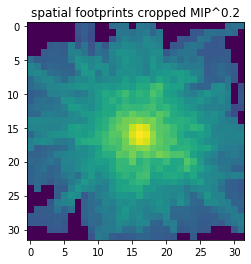

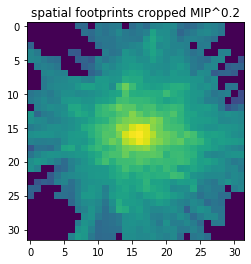

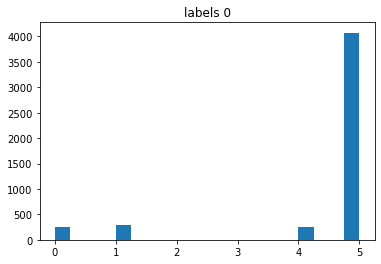

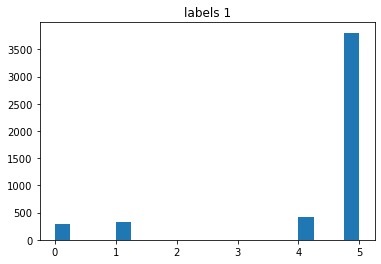

In [9]:
dir_folders = f'{base_dir}/label_data'
# dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
# dir_folders = r'/users/Josh/Documents/Harvard/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                            fileNames_statFiles=fileNames_statFiles,
                                            out_height_width=[32,32],
                                            max_footprint_width=241,
                                            plot_pref=True)
images_labeled_raw = np.concatenate(sf_all, axis=0)
images_labeled_raw = (images_labeled_raw / np.max(images_labeled_raw, axis=(1,2), keepdims=True)) * 1
print(f'concatenated images shape: {images_labeled_raw.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels_raw = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

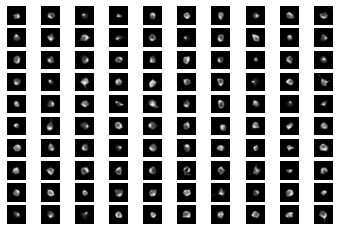

In [10]:
%matplotlib inline

plotting_helpers.plot_image_grid(images=images_labeled_raw,
                                labels=None,
                                grid_shape=(10,10), cmap=plt.get_cmap('gray'));

In [11]:
labels = classification.squeeze_integers(labels_raw)
images_labeled = images_labeled_raw[labels != 2]
labels = labels[labels != 2]
labels = classification.squeeze_integers(labels)

## Balance classes of inputs

In [12]:
duplicates = 1
balanced = True

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

if balanced:
    numToGetTo = np.sum(labels_dup==0)
    print(numToGetTo)
    for ii in np.array([1,2,3]):
  #     idxToDelete = np.cumsum(labels_dup==ii) <= (np.sum(labels_dup==ii) - numToGetTo)
        if ii==3:
            numToGetTo = np.sum(labels_dup==0)/1
        else:
            numToGetTo = np.sum(labels_dup==0)

        idxToDelete = (np.cumsum(labels_dup==ii) * (labels_dup==ii)) > numToGetTo
        images_dup = images_dup[idxToDelete==0,:,:]
        labels_dup = labels_dup[idxToDelete==0]





print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9714, 32, 32)
(9714,)
532
(2128, 32, 32)
(2128,)
532
532
532
0
0
(2128, 32, 32)
(2128,)


In [13]:
# create validation set

###### REMOVE WITH ENOUGH RAM
images = images_dup
labels = labels_dup

# X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.3)
X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.2)
# X_train, y_train = X_labeled_train, y_labeled_train

# X_labeled_val, X_test, y_labeled_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)
X_val, X_test, y_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)

(X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

(((1702, 32, 32), (1702,)), ((426, 32, 32), (426,)))

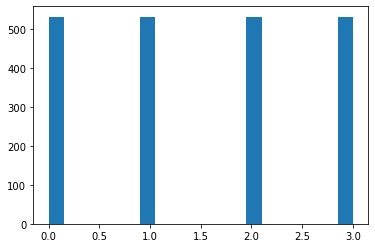

In [14]:
plt.figure()
plt.hist(labels_dup, 20);

In [15]:
images.shape

(2128, 32, 32)

# Train

In [16]:
DEVICE = torch_helpers.set_device(use_GPU=True)
# DEVICE = torch_helpers.set_device(use_GPU=False)

device: 'cuda'


### Define New model = model + pre-head + latent layer OR classification layer

In [17]:
class ModelTackOn(torch.nn.Module):
    def __init__(self, base_model, un_modified_model, pre_head_fc_sizes=[100], post_head_fc_sizes=[100], classifier_fc_sizes=None):
            super(ModelTackOn, self).__init__()
            self.base_model = base_model
            final_base_layer = list(un_modified_model.children())[-1]
            # final_base_layer = list(list(model.children())[-1].children())[-1]
            # print(final_base_layer)

            self.pre_head_fc_lst = []
            self.post_head_fc_lst = []
            self.classifier_fc_lst = []

            self.init_prehead(final_base_layer, pre_head_fc_sizes)
            self.init_posthead(pre_head_fc_sizes[-1], post_head_fc_sizes)
            if classifier_fc_sizes is not None:
                self.init_classifier(pre_head_fc_sizes[-1], classifier_fc_sizes)
    
    def init_prehead(self, prv_layer, pre_head_fc_sizes):
        for i, pre_head_fc in enumerate(pre_head_fc_sizes):
            if i == 0:
                in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 1280
            else:
                in_features = pre_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=pre_head_fc)
            self.add_module(f'PreHead_{i}', fc_layer)
            self.pre_head_fc_lst.append(fc_layer)

#             if i < len(pre_head_fc_sizes) - 1:
            non_linearity = torch.nn.ReLU()
            self.add_module(f'PreHead_{i}_NonLinearity', non_linearity)
            self.pre_head_fc_lst.append(non_linearity)

    def init_posthead(self, prv_size, post_head_fc_sizes):
        for i, post_head_fc in enumerate(post_head_fc_sizes):
            if i == 0:
                in_features = prv_size
            else:
                in_features = post_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=post_head_fc)
            self.add_module(f'PostHead_{i}', fc_layer)
            self.post_head_fc_lst.append(fc_layer)

            if i < len(post_head_fc_sizes) - 1:
                non_linearity = torch.nn.ReLU()
                self.add_module(f'PostHead_{i}_NonLinearity', non_linearity)
                self.pre_head_fc_lst.append(non_linearity)
    
    def init_classifier(self, prv_size, classifier_fc_sizes):
            for i, classifier_fc in enumerate(classifier_fc_sizes):
                if i == 0:
                    in_features = prv_size
                else:
                    in_features = classifier_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=classifier_fc)
            self.add_module(f'Classifier_{i}', fc_layer)
            self.classifier_fc_lst.append(fc_layer)

    def reinit_classifier(self):
        for i_layer, layer in enumerate(self.classifier_fc_lst):
            layer.reset_parameters()
    
#     def forward(self, X):
#         interim = self.base_model(X)
#         interim = self.get_head(interim)
#         interim = self.get_latent(interim)
#         return interim

    def forward_classifier(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.classify(interim)
        return interim

    def forward_latent(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.get_latent(interim)
        return interim


    def get_head(self, base_out):
        # print('base_out', base_out.shape)
        head = base_out
        for pre_head_layer in self.pre_head_fc_lst:
          # print('pre_head_layer', pre_head_layer.in_features)
          head = pre_head_layer(head)
          # print('head', head.shape)
        return head

    def get_latent(self, head):
        latent = head
        for post_head_layer in self.post_head_fc_lst:
            latent = post_head_layer(latent)
        return latent

    def classify(self, head):
        logit = head
        for classifier_layer in self.classifier_fc_lst:
            logit = classifier_layer(logit)
        return logit

    def set_pre_head_grad(self, requires_grad=True):
        for layer in self.pre_head_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad
                
    def set_post_head_grad(self, requires_grad=True):
        for layer in self.post_head_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def set_classifier_grad(self, requires_grad=True):
        for layer in self.classifier_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def prep_contrast(self):
        self.set_pre_head_grad(requires_grad=True)
        self.set_post_head_grad(requires_grad=True)
        self.set_classifier_grad(requires_grad=False)

    def prep_classifier(self):
        self.set_pre_head_grad(requires_grad=False)
        self.set_post_head_grad(requires_grad=False)
        self.set_classifier_grad(requires_grad=True)


In [18]:
# import torchvision.models

# # base_model = torchvision.models.resnet101(pretrained=True)
# base_model = torchvision.models.resnet18(pretrained=True)

# for param in base_model.parameters():
#     param.requires_grad = False

# retrain = list(base_model.children())[-1:]
# for layer in retrain:
#     params = layer.parameters()
#     for param in params:
#         param.requires_grad = True

In [19]:
import torchvision.models

# base_model_frozen = torchvision.models.resnet101(pretrained=True)
# base_model_frozen = torchvision.models.resnet18(pretrained=True)
# base_model_frozen = torchvision.models.wide_resnet50_2(pretrained=True)
# base_model_frozen = torchvision.models.resnet50(pretrained=True)

base_model_frozen = torchvision.models.efficientnet_b0(pretrained=True)


for param in base_model_frozen.parameters():
    param.requires_grad = False

start with a pretrained resnet model, and chop off the final layer. This will be used as the base on which we add the pre-head layers (for expressivity), latent layers (for simCLR), or classification layers (for post-hoc logistic regression)

In [20]:
model_chopped = torch.nn.Sequential(*(list(base_model_frozen.children())[:-1] + [torch.nn.Flatten()]))

### Make combined model
'model' has two forward methods. One for generating latents (for simCLR) and one for classifying labels

In [21]:
model = ModelTackOn(model_chopped, base_model_frozen, pre_head_fc_sizes=[1024, 512], post_head_fc_sizes=[64], classifier_fc_sizes=[len(np.unique(y_labeled_train))])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])

# model = torch.nn.Sequential([model_chopped.to(DEVICE), torch.nn.Linear], pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])


# model = ModelTackOn(base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(base_model, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
model.train();

In [22]:
# unfreeze particular blocks in ResNet model

for name, param in list(model.named_parameters()):
    # print(name)
    if name[:10] == 'base_model':
        if int(name[13]) < 7:
            param.requires_grad = False
        elif int(name[13]) >= 7:
            param.requires_grad = True

for name, param in list(model.named_parameters()):
    if param.requires_grad:
        print(name)

base_model.0.7.0.block.0.0.weight
base_model.0.7.0.block.0.1.weight
base_model.0.7.0.block.0.1.bias
base_model.0.7.0.block.1.0.weight
base_model.0.7.0.block.1.1.weight
base_model.0.7.0.block.1.1.bias
base_model.0.7.0.block.2.fc1.weight
base_model.0.7.0.block.2.fc1.bias
base_model.0.7.0.block.2.fc2.weight
base_model.0.7.0.block.2.fc2.bias
base_model.0.7.0.block.3.0.weight
base_model.0.7.0.block.3.1.weight
base_model.0.7.0.block.3.1.bias
base_model.0.8.0.weight
base_model.0.8.1.weight
base_model.0.8.1.bias
PreHead_0.weight
PreHead_0.bias
PreHead_1.weight
PreHead_1.bias
PostHead_0.weight
PostHead_0.bias
Classifier_0.weight
Classifier_0.bias


## Define augmentation pipeline

In [23]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
        
    torchvision.transforms.RandomAffine(
                                        degrees=(-180,180),
                                        translate=(0.15, 0.15), #0, .3, .45 (DEFAULT)
                                        scale=(0.6, 1.2), # no scale (1,1), (0.4, 1.5)
                                        shear=(-15, 15, -15, 15),
                                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                        fill=0, 
                                        fillcolor=None, 
                                        resample=None),
    augmentation.AddPoissonNoise(   #scaler_bounds=(10**(4.5), 10**(6.)),
                                    scaler_bounds=(10**(4), 10**(6)),
                                    prob=1,
                                    base=1000,
                                    scaling='log'),
    augmentation.AddGaussianNoise(  mean=0, 
                                    std=0.00015,
                                    prob=1),
    
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)), # just clamping, both this and clamping = normalizing (DEFAULT)
    torchvision.transforms.Resize(size=(224,224), 
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # To do or not to do (DEFAULT)
    
    augmentation.TileChannels(dim=0, n_channels=3),
)
    
scripted_transforms = torch.jit.script(transforms)

In [24]:
dataset_train = util.dataset_simCLR(
                                    torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=2,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_train = torch.utils.data.DataLoader( dataset_train,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=800,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=16,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

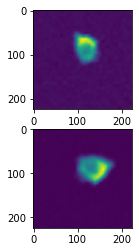

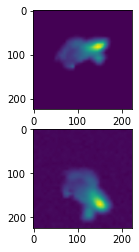

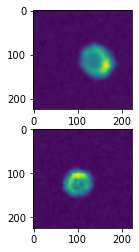

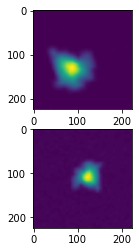

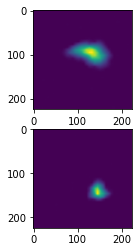

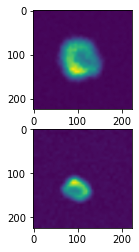

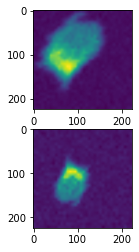

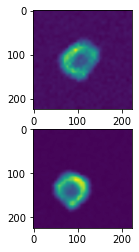

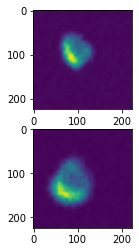

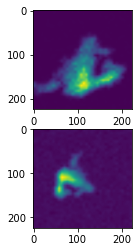

In [25]:
idx_rand = np.random.randint(0,masks_cat.shape[0], 10)
for ii in idx_rand:
    fig, axs = plt.subplots(2)
    axs[0].imshow(dataset_train[ii][0][0][0])
    axs[1].imshow(dataset_train[ii][0][1][0])

In [26]:
# torch_helpers.delete_all_cuda_tensors(globals())

import gc

torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

## Training

In [27]:
model.to(DEVICE)
model.prep_contrast()

In [28]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=64)


criterion = [CrossEntropyLoss()]
# criterion = CrossEntropyLoss(reduction='none')

# optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
# optimizer = Adam(model.parameters(), lr=2e-2)
optimizer = Adam(model.parameters(), lr=10**(-3.5))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0000,
#                                                    gamma=1,
                                                  )

criterion = [_.to(DEVICE) for _ in criterion]
losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [29]:
def get_ds_dl(data, transforms, expand_dim=False):
    setup_ds = util.dataset_simCLR(
                                    torch.as_tensor(data, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(data.shape[0]), device='cpu', dtype=torch.float32),


                                    n_transforms=1,
                                    transform=transforms,
                                    class_weights=np.array([1]),
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,

                                    temp_uncertainty=16,
                                    expand_dim=expand_dim
                                    )
    setup_dl = torch.utils.data.DataLoader( setup_ds,
                                            batch_size=1024,
                                            shuffle=False,
                                            drop_last=False,
                                            # pin_memory=True,
                                            # num_workers=16,
                                            # persistent_workers=True,
                                            )

    return setup_ds, setup_dl

In [30]:
X_labeled_train.shape

(1702, 32, 32)

In [31]:
all_transforms = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),
)
no_transforms = torch.nn.Sequential(
)
scale_rsz_transforms = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
)
tile_transforms = torch.nn.Sequential(
    augmentation.TileChannels(dim=0, n_channels=3),
)


scripted_all_transforms = torch.jit.script(all_transforms)
scripted_no_transforms = torch.jit.script(no_transforms)
scripted_scale_rsz_transform = torch.jit.script(scale_rsz_transforms)
scripted_tile_transform = torch.jit.script(tile_transforms)

In [32]:
setup_transform = scripted_scale_rsz_transform
run_transform = scripted_tile_transform

setup_ds, setup_dl = get_ds_dl(X_labeled_train, setup_transform, expand_dim=True)
input_xtr = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)
setup_ds, setup_dl = get_ds_dl(X_labeled_train_SYT, setup_transform, expand_dim=True)
input_xtr_SYT = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)

setup_ds, setup_dl = get_ds_dl(X_labeled_val, setup_transform, expand_dim=True)
input_xval = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)
setup_ds, setup_dl = get_ds_dl(X_labeled_val_SYT, setup_transform, expand_dim=True)
input_xval_SYT = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)

# print("Starting!")
# tik = time.time()
# ds_run = util.dataset_simCLR(
#                             torch.as_tensor(input_x, device='cpu', dtype=torch.float32), 
#                             torch.as_tensor(torch.zeros(input_x.shape[0]), device='cpu', dtype=torch.float32),

#                             n_transforms=1,
#                             class_weights=np.array([1]),
#                             transform=run_transform,
#                             DEVICE='cpu',
#                             dtype_X=torch.float32,
#                             dtype_y=torch.int64,

#                             temp_uncertainty=16,
#                             expand_dim=False
#                             )
# dl_run = torch.utils.data.DataLoader( ds_run,
#                                         batch_size=1024,
#                                         shuffle=False,
#                                         drop_last=False,
#                                         # pin_memory=True,
#                                         # num_workers=16,
#                                         # persistent_workers=True,
#                                         )
# features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
# tok = time.time()

# print(f'Tile Transformation Alone Took: {tok-tik} s to run')

In [33]:
input_xtr.shape, input_xtr_SYT.shape, input_xval.shape, input_xval_SYT.shape

(torch.Size([1702, 1, 224, 224]),
 torch.Size([54704, 1, 224, 224]),
 torch.Size([426, 1, 224, 224]),
 torch.Size([13677, 1, 224, 224]))

In [34]:
# scale_rsz_transforms = torch.nn.Sequential(
#     augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
#     torchvision.transforms.Resize(size=(224,224),
#                                   interpolation=torchvision.transforms.InterpolationMode.BILINEAR))
# tile_transforms = torch.nn.Sequential(augmentation.TileChannels(dim=0, n_channels=3),)


# scripted_scale_rsz_transform = torch.jit.script(scale_rsz_transforms)
# scripted_tile_transform = torch.jit.script(tile_transforms)


# setup_transform = scripted_scale_rsz_transform
# run_transform = scripted_tile_transform



# # setup_ds, setup_dl = get_ds_dl(X_labeled_train_SYT, setup_transform, expand_dim=False)

# setup_ds = util.dataset_simCLR(
#                                 torch.as_tensor(X_labeled_train_SYT, device='cpu', dtype=torch.float32), 
#                                 torch.as_tensor(torch.zeros(X_labeled_train_SYT.shape[0]), device='cpu', dtype=torch.float32),
#                                 n_transforms=1,
#                                 transform=setup_transform,
#                                 class_weights=np.array([1]),
#                                 DEVICE='cpu',
#                                 dtype_X=torch.float32,
#                                 dtype_y=torch.int64,

#                                 temp_uncertainty=16,
#                                 expand_dim=False
#                                 )
# setup_dl = torch.utils.data.DataLoader( setup_ds,
#                                         batch_size=1024,
#                                         shuffle=False,
#                                         drop_last=False,
#                                         # pin_memory=True,
#                                         # num_workers=16,
#                                         # persistent_workers=True,
#                                         )


# input_x = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)
# # setup_ds, setup_dl = get_ds_dl(X_labeled_train_SYT, setup_transform, expand_dim=False)
# # input_x_SYT = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)



In [35]:
# acc_train_lst, acc_val_lst = [], []
# acc_train_SYT_lst, acc_val_SYT_lst = [], []

# print('A')
# ds_run, dl_run = get_ds_dl(input_xtr, run_transform, expand_dim=False)
# features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
# ds_run, dl_run = get_ds_dl(input_xval, run_transform, expand_dim=False)
# features_val = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)

# print('B')
# ds_run, dl_run = get_ds_dl(input_xtr_SYT, run_transform, expand_dim=False)
# features_train_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
# ds_run, dl_run = get_ds_dl(input_xval_SYT, run_transform, expand_dim=False)
# features_val_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)


# acc_train, acc_val = {}, {}
# acc_train_SYT, acc_val_SYT = {}, {}
# C_toUse = np.array([1e1,1e0,1e-1,1e-2])
# for C in C_toUse:
#     print('C1')
#     logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#     logreg.fit(features_train, y_labeled_train)
#     acc_train_tmp = logreg.score(features_train, y_labeled_train)
#     acc_train[C] = acc_train_tmp
#     acc_val_tmp = logreg.score(features_val, y_labeled_val)
#     acc_val[C] = acc_val_tmp
    
#     print('C2')
#     logreg_SYT = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#     logreg_SYT.fit(features_train_SYT, y_labeled_train_SYT)
#     acc_train_tmp = logreg_SYT.score(features_train_SYT, y_labeled_train_SYT)
#     acc_train_SYT[C] = acc_train_tmp
#     acc_val_tmp = logreg_SYT.score(features_val_SYT, y_labeled_val_SYT)
#     acc_val_SYT[C] = acc_val_tmp

# acc_train_lst.append(acc_train)
# acc_val_lst.append(acc_val)
# acc_train_SYT_lst.append(acc_train_SYT)
# acc_val_SYT_lst.append(acc_val_SYT)


# losses_train_npy = np.array(losses_train)
# losses_val_npy = np.array(losses_val)
# val_accs_npy = np.array(val_accs)
# acc_npy = np.array(acc)

In [36]:
# acc_train_df, acc_val_df, acc_train_SYT_df, acc_val_SYT_df = pd.DataFrame(acc_train_lst), pd.DataFrame(acc_val_lst), pd.DataFrame(acc_train_SYT_lst), pd.DataFrame(acc_val_SYT_lst)
# display(acc_train_df)
# display(acc_val_df)
# display(acc_train_SYT_df)
# display(acc_val_SYT_df)

# acc_train_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_train.csv')
# acc_val_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_val.csv')
# acc_train_SYT_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_train_SYT.csv')
# acc_val_SYT_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_val_SYT.csv')

In [37]:
model_file_name = 'ResNet18_simCLR_model_202112078_EOD_transfmod=efficient2-only7unfrozen'
model.forward = model.forward_latent

In [ ]:
l2_alpha = 0.000
n_epochs=300000

acc_train_lst, acc_val_lst = [], []
acc_train_SYT_lst, acc_val_SYT_lst = [], []

for epoch in tqdm(range(n_epochs)):
    print(f'epoch: {epoch}')
    
    ds_run, dl_run = get_ds_dl(input_xtr, run_transform, expand_dim=False)
    features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
    ds_run, dl_run = get_ds_dl(input_xval, run_transform, expand_dim=False)
    features_val = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
    
    ds_run, dl_run = get_ds_dl(input_xtr_SYT, run_transform, expand_dim=False)
    features_train_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
    ds_run, dl_run = get_ds_dl(input_xval_SYT, run_transform, expand_dim=False)
    features_val_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)


    acc_train, acc_val = {}, {}
    acc_train_SYT, acc_val_SYT = {}, {}
    C_toUse = np.array([1e1,1e0,1e-1,1e-2])
    for C in C_toUse:
        logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
        logreg.fit(features_train, y_labeled_train)
        acc_train_tmp = logreg.score(features_train, y_labeled_train)
        acc_train[C] = acc_train_tmp
        acc_val_tmp = logreg.score(features_val, y_labeled_val)
        acc_val[C] = acc_val_tmp
        
        logreg_SYT = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
        logreg_SYT.fit(features_train_SYT, y_labeled_train_SYT)
        acc_train_tmp = logreg_SYT.score(features_train_SYT, y_labeled_train_SYT)
        acc_train_SYT[C] = acc_train_tmp
        acc_val_tmp = logreg_SYT.score(features_val_SYT, y_labeled_val_SYT)
        acc_val_SYT[C] = acc_val_tmp

    acc_train_lst.append(acc_train)
    acc_val_lst.append(acc_val)
    acc_train_SYT_lst.append(acc_train_SYT)
    acc_val_SYT_lst.append(acc_val_SYT)

    acc_train_df, acc_val_df, acc_train_SYT_df, acc_val_SYT_df = pd.DataFrame(acc_train_lst), pd.DataFrame(acc_val_lst), pd.DataFrame(acc_train_SYT_lst), pd.DataFrame(acc_val_SYT_lst)
    
    acc_train_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_train.csv')
    acc_train_SYT_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_train_SYT.csv')
    acc_val_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_val.csv')
    acc_val_SYT_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_val_SYT.csv')
    
    
    loss_rolling_train = training_simCLR.epoch_step(dataloader_train, 
                                    model, 
                                    optimizer, 
                                    criterion,
                                    scheduler=scheduler,
                                    temperature=0.5,
                                    # l2_alpha,
                                    mode='semi-supervised',
                                    loss_rolling_train=losses_train, 
                                    loss_rolling_val=losses_val,
                                    device=DEVICE, 
                                    verbose=2,
                                    verbose_update_period=1,
                                   
#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )
    
    
    torch.save(model.state_dict(), f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/{model_file_name}.pth')
   
    
    losses_train_npy = np.array(losses_train)
    losses_val_npy = np.array(losses_val)
    val_accs_npy = np.array(val_accs)
    acc_npy = np.array(acc)

    np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_losses_train.npy', losses_train_npy)
    np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_losses_val.npy', losses_val_npy)
    np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_val_accs.npy', val_accs_npy)
    np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_tr_accs.npy', acc_npy)

  0%|          | 0/300000 [00:00<?, ?it/s]

epoch: 0
Iter: 0/889, loss_train: 7.349, loss_val: nan, pos_over_neg: 1.0245325565338135 lr: 0.00031623
Iter: 1/889, loss_train: 7.1765, loss_val: nan, pos_over_neg: 1.2428301572799683 lr: 0.00031623
Iter: 2/889, loss_train: 6.9988, loss_val: nan, pos_over_neg: 3.1196725368499756 lr: 0.00031623
Iter: 3/889, loss_train: 6.9009, loss_val: nan, pos_over_neg: 3.7103147506713867 lr: 0.00031623
Iter: 4/889, loss_train: 6.7802, loss_val: nan, pos_over_neg: 4.077817916870117 lr: 0.00031623
Iter: 5/889, loss_train: 6.7269, loss_val: nan, pos_over_neg: 5.723012447357178 lr: 0.00031623
Iter: 6/889, loss_train: 6.6701, loss_val: nan, pos_over_neg: 9.695016860961914 lr: 0.00031623
Iter: 7/889, loss_train: 6.6192, loss_val: nan, pos_over_neg: 13.35693073272705 lr: 0.00031623
Iter: 8/889, loss_train: 6.5942, loss_val: nan, pos_over_neg: 12.405990600585938 lr: 0.00031623
Iter: 9/889, loss_train: 6.5699, loss_val: nan, pos_over_neg: 13.105032920837402 lr: 0.00031623
Iter: 10/889, loss_train: 6.5927, lo

  0%|          | 1/300000 [25:06<125525:33:55, 1506.31s/it]

epoch: 1
Iter: 0/889, loss_train: 5.9379, loss_val: nan, pos_over_neg: 836.7720947265625 lr: 0.00031623
Iter: 1/889, loss_train: 5.9342, loss_val: nan, pos_over_neg: 302.8044738769531 lr: 0.00031623
Iter: 2/889, loss_train: 5.9302, loss_val: nan, pos_over_neg: 2447.04052734375 lr: 0.00031623
Iter: 3/889, loss_train: 5.9191, loss_val: nan, pos_over_neg: 1052.4263916015625 lr: 0.00031623
Iter: 4/889, loss_train: 5.9281, loss_val: nan, pos_over_neg: 342.2099609375 lr: 0.00031623
Iter: 5/889, loss_train: 5.9343, loss_val: nan, pos_over_neg: 391.80157470703125 lr: 0.00031623
Iter: 6/889, loss_train: 5.9256, loss_val: nan, pos_over_neg: 349.9445495605469 lr: 0.00031623
Iter: 7/889, loss_train: 5.936, loss_val: nan, pos_over_neg: 673.9456176757812 lr: 0.00031623
Iter: 8/889, loss_train: 5.9228, loss_val: nan, pos_over_neg: 675.8674926757812 lr: 0.00031623
Iter: 9/889, loss_train: 5.9235, loss_val: nan, pos_over_neg: 692.7626953125 lr: 0.00031623
Iter: 10/889, loss_train: 5.9405, loss_val: nan

  0%|          | 2/300000 [51:15<128593:49:30, 1543.14s/it]

epoch: 2
Iter: 0/889, loss_train: 5.8744, loss_val: nan, pos_over_neg: 1075.176513671875 lr: 0.00031623
Iter: 1/889, loss_train: 5.8632, loss_val: nan, pos_over_neg: 6245.3291015625 lr: 0.00031623
Iter: 2/889, loss_train: 5.8873, loss_val: nan, pos_over_neg: 355.1353454589844 lr: 0.00031623
Iter: 3/889, loss_train: 5.884, loss_val: nan, pos_over_neg: 1739.677978515625 lr: 0.00031623
Iter: 4/889, loss_train: 5.8695, loss_val: nan, pos_over_neg: 1063.34521484375 lr: 0.00031623
Iter: 5/889, loss_train: 5.874, loss_val: nan, pos_over_neg: 4997.0244140625 lr: 0.00031623
Iter: 6/889, loss_train: 5.8581, loss_val: nan, pos_over_neg: 4643.34716796875 lr: 0.00031623
Iter: 7/889, loss_train: 5.8731, loss_val: nan, pos_over_neg: 2999.383544921875 lr: 0.00031623
Iter: 8/889, loss_train: 5.8703, loss_val: nan, pos_over_neg: 543.8554077148438 lr: 0.00031623
Iter: 9/889, loss_train: 5.871, loss_val: nan, pos_over_neg: 452.1960754394531 lr: 0.00031623
Iter: 10/889, loss_train: 5.8793, loss_val: nan, p

  0%|          | 3/300000 [1:16:46<128159:55:32, 1537.93s/it]

epoch: 3
Iter: 0/889, loss_train: 5.8443, loss_val: nan, pos_over_neg: 2466.065673828125 lr: 0.00031623
Iter: 1/889, loss_train: 5.8468, loss_val: nan, pos_over_neg: 1065.8143310546875 lr: 0.00031623
Iter: 2/889, loss_train: 5.8479, loss_val: nan, pos_over_neg: 981.7886962890625 lr: 0.00031623
Iter: 3/889, loss_train: 5.8633, loss_val: nan, pos_over_neg: 303.48638916015625 lr: 0.00031623
Iter: 4/889, loss_train: 5.8515, loss_val: nan, pos_over_neg: 666.6537475585938 lr: 0.00031623
Iter: 5/889, loss_train: 5.8663, loss_val: nan, pos_over_neg: 701.0667114257812 lr: 0.00031623
Iter: 6/889, loss_train: 5.8415, loss_val: nan, pos_over_neg: 1000.0113525390625 lr: 0.00031623
Iter: 7/889, loss_train: 5.8397, loss_val: nan, pos_over_neg: 1011.1612548828125 lr: 0.00031623
Iter: 8/889, loss_train: 5.8419, loss_val: nan, pos_over_neg: 821.1480102539062 lr: 0.00031623
Iter: 9/889, loss_train: 5.8444, loss_val: nan, pos_over_neg: 809.2012329101562 lr: 0.00031623
Iter: 10/889, loss_train: 5.8408, los

  0%|          | 4/300000 [1:42:51<129040:50:08, 1548.51s/it]

epoch: 4
Iter: 0/889, loss_train: 5.8283, loss_val: nan, pos_over_neg: 1332.977294921875 lr: 0.00031623
Iter: 1/889, loss_train: 5.8208, loss_val: nan, pos_over_neg: 1484.685791015625 lr: 0.00031623
Iter: 2/889, loss_train: 5.8366, loss_val: nan, pos_over_neg: 1532.5133056640625 lr: 0.00031623
Iter: 3/889, loss_train: 5.8406, loss_val: nan, pos_over_neg: 791.9417724609375 lr: 0.00031623
Iter: 4/889, loss_train: 5.8051, loss_val: nan, pos_over_neg: 1258.7066650390625 lr: 0.00031623
Iter: 5/889, loss_train: 5.8329, loss_val: nan, pos_over_neg: 1033.0068359375 lr: 0.00031623
Iter: 6/889, loss_train: 5.8401, loss_val: nan, pos_over_neg: 681.4507446289062 lr: 0.00031623
Iter: 7/889, loss_train: 5.8167, loss_val: nan, pos_over_neg: 3315.596923828125 lr: 0.00031623
Iter: 8/889, loss_train: 5.8535, loss_val: nan, pos_over_neg: 401.41900634765625 lr: 0.00031623
Iter: 9/889, loss_train: 5.8074, loss_val: nan, pos_over_neg: 909.55322265625 lr: 0.00031623
Iter: 10/889, loss_train: 5.8189, loss_val

  0%|          | 5/300000 [2:08:51<129366:41:38, 1552.43s/it]

epoch: 5
Iter: 0/889, loss_train: 5.8128, loss_val: nan, pos_over_neg: 989.0838623046875 lr: 0.00031623
Iter: 1/889, loss_train: 5.8311, loss_val: nan, pos_over_neg: 1221.1290283203125 lr: 0.00031623
Iter: 2/889, loss_train: 5.8083, loss_val: nan, pos_over_neg: 845.54150390625 lr: 0.00031623
Iter: 3/889, loss_train: 5.8119, loss_val: nan, pos_over_neg: 856.6835327148438 lr: 0.00031623
Iter: 4/889, loss_train: 5.8184, loss_val: nan, pos_over_neg: 1451.4873046875 lr: 0.00031623
Iter: 5/889, loss_train: 5.8216, loss_val: nan, pos_over_neg: 725.66845703125 lr: 0.00031623
Iter: 6/889, loss_train: 5.8137, loss_val: nan, pos_over_neg: 1577.31640625 lr: 0.00031623
Iter: 7/889, loss_train: 5.8044, loss_val: nan, pos_over_neg: 379.6065979003906 lr: 0.00031623
Iter: 8/889, loss_train: 5.8142, loss_val: nan, pos_over_neg: 728.5592041015625 lr: 0.00031623
Iter: 9/889, loss_train: 5.8272, loss_val: nan, pos_over_neg: 473.2219543457031 lr: 0.00031623
Iter: 10/889, loss_train: 5.8211, loss_val: nan, p

  0%|          | 6/300000 [2:34:07<128353:43:49, 1540.28s/it]

epoch: 6
Iter: 0/889, loss_train: 5.8031, loss_val: nan, pos_over_neg: -63498.40234375 lr: 0.00031623
Iter: 1/889, loss_train: 5.8007, loss_val: nan, pos_over_neg: -1404.64404296875 lr: 0.00031623
Iter: 2/889, loss_train: 5.8035, loss_val: nan, pos_over_neg: 778.8506469726562 lr: 0.00031623
Iter: 3/889, loss_train: 5.8194, loss_val: nan, pos_over_neg: 431.81549072265625 lr: 0.00031623
Iter: 4/889, loss_train: 5.823, loss_val: nan, pos_over_neg: 2049.84912109375 lr: 0.00031623
Iter: 5/889, loss_train: 5.7874, loss_val: nan, pos_over_neg: 669.4655151367188 lr: 0.00031623
Iter: 6/889, loss_train: 5.8208, loss_val: nan, pos_over_neg: 955.7408447265625 lr: 0.00031623
Iter: 7/889, loss_train: 5.8072, loss_val: nan, pos_over_neg: 400.49609375 lr: 0.00031623
Iter: 8/889, loss_train: 5.8063, loss_val: nan, pos_over_neg: 3292.92236328125 lr: 0.00031623
Iter: 9/889, loss_train: 5.8218, loss_val: nan, pos_over_neg: 795.2947387695312 lr: 0.00031623
Iter: 10/889, loss_train: 5.8104, loss_val: nan, p

  0%|          | 7/300000 [3:00:07<128873:59:37, 1546.52s/it]

epoch: 7
Iter: 0/889, loss_train: 5.8009, loss_val: nan, pos_over_neg: 428.9358825683594 lr: 0.00031623
Iter: 1/889, loss_train: 5.7974, loss_val: nan, pos_over_neg: 697.8335571289062 lr: 0.00031623
Iter: 2/889, loss_train: 5.7973, loss_val: nan, pos_over_neg: 1150.2855224609375 lr: 0.00031623
Iter: 3/889, loss_train: 5.7866, loss_val: nan, pos_over_neg: 913.9742431640625 lr: 0.00031623
Iter: 4/889, loss_train: 5.8009, loss_val: nan, pos_over_neg: 772.8807373046875 lr: 0.00031623
Iter: 5/889, loss_train: 5.7836, loss_val: nan, pos_over_neg: 2086.922607421875 lr: 0.00031623
Iter: 6/889, loss_train: 5.8033, loss_val: nan, pos_over_neg: 1660.8465576171875 lr: 0.00031623
Iter: 7/889, loss_train: 5.8071, loss_val: nan, pos_over_neg: 436.9815368652344 lr: 0.00031623
Iter: 8/889, loss_train: 5.7898, loss_val: nan, pos_over_neg: 978.3173828125 lr: 0.00031623
Iter: 9/889, loss_train: 5.7844, loss_val: nan, pos_over_neg: 526.50732421875 lr: 0.00031623
Iter: 10/889, loss_train: 5.7882, loss_val: 

  0%|          | 8/300000 [3:25:28<128194:32:29, 1538.38s/it]

epoch: 8
Iter: 0/889, loss_train: 5.7909, loss_val: nan, pos_over_neg: 574.9132690429688 lr: 0.00031623
Iter: 1/889, loss_train: 5.7723, loss_val: nan, pos_over_neg: 1261.04443359375 lr: 0.00031623
Iter: 2/889, loss_train: 5.7773, loss_val: nan, pos_over_neg: 667.598876953125 lr: 0.00031623
Iter: 3/889, loss_train: 5.793, loss_val: nan, pos_over_neg: 537.9375610351562 lr: 0.00031623
Iter: 4/889, loss_train: 5.7769, loss_val: nan, pos_over_neg: 1142.9503173828125 lr: 0.00031623
Iter: 5/889, loss_train: 5.7778, loss_val: nan, pos_over_neg: 565.7656860351562 lr: 0.00031623
Iter: 6/889, loss_train: 5.7962, loss_val: nan, pos_over_neg: 266.8775939941406 lr: 0.00031623
Iter: 7/889, loss_train: 5.7828, loss_val: nan, pos_over_neg: 857.7625122070312 lr: 0.00031623
Iter: 8/889, loss_train: 5.7986, loss_val: nan, pos_over_neg: 348.0204772949219 lr: 0.00031623
Iter: 9/889, loss_train: 5.7978, loss_val: nan, pos_over_neg: -3387.114501953125 lr: 0.00031623
Iter: 10/889, loss_train: 5.7852, loss_val

  0%|          | 9/300000 [3:50:51<127815:39:07, 1533.83s/it]

epoch: 9
Iter: 0/889, loss_train: 5.7981, loss_val: nan, pos_over_neg: 485.3573913574219 lr: 0.00031623
Iter: 1/889, loss_train: 5.7786, loss_val: nan, pos_over_neg: 610.9149169921875 lr: 0.00031623
Iter: 2/889, loss_train: 5.7923, loss_val: nan, pos_over_neg: 495.6209411621094 lr: 0.00031623
Iter: 3/889, loss_train: 5.7848, loss_val: nan, pos_over_neg: 1354.791748046875 lr: 0.00031623
Iter: 4/889, loss_train: 5.787, loss_val: nan, pos_over_neg: 618.1541137695312 lr: 0.00031623
Iter: 5/889, loss_train: 5.7835, loss_val: nan, pos_over_neg: 1678.892822265625 lr: 0.00031623
Iter: 6/889, loss_train: 5.7945, loss_val: nan, pos_over_neg: 442.46038818359375 lr: 0.00031623
Iter: 7/889, loss_train: 5.7951, loss_val: nan, pos_over_neg: 2437.3525390625 lr: 0.00031623
Iter: 8/889, loss_train: 5.791, loss_val: nan, pos_over_neg: 701.01416015625 lr: 0.00031623
Iter: 9/889, loss_train: 5.7731, loss_val: nan, pos_over_neg: 1733.4007568359375 lr: 0.00031623
Iter: 10/889, loss_train: 5.7766, loss_val: n

  0%|          | 10/300000 [4:16:39<128161:11:08, 1537.99s/it]

epoch: 10
Iter: 0/889, loss_train: 5.7884, loss_val: nan, pos_over_neg: 305.7594909667969 lr: 0.00031623
Iter: 1/889, loss_train: 5.7814, loss_val: nan, pos_over_neg: 691.5698852539062 lr: 0.00031623
Iter: 2/889, loss_train: 5.772, loss_val: nan, pos_over_neg: 1710.261474609375 lr: 0.00031623
Iter: 3/889, loss_train: 5.7665, loss_val: nan, pos_over_neg: 1404.9296875 lr: 0.00031623
Iter: 4/889, loss_train: 5.7951, loss_val: nan, pos_over_neg: 1866.737548828125 lr: 0.00031623
Iter: 5/889, loss_train: 5.7866, loss_val: nan, pos_over_neg: 689.5929565429688 lr: 0.00031623
Iter: 6/889, loss_train: 5.7682, loss_val: nan, pos_over_neg: 9876.3974609375 lr: 0.00031623
Iter: 7/889, loss_train: 5.7813, loss_val: nan, pos_over_neg: 420.05859375 lr: 0.00031623
Iter: 8/889, loss_train: 5.7844, loss_val: nan, pos_over_neg: 639.0506591796875 lr: 0.00031623
Iter: 9/889, loss_train: 5.7801, loss_val: nan, pos_over_neg: 955.7430419921875 lr: 0.00031623
Iter: 10/889, loss_train: 5.7926, loss_val: nan, pos_

  0%|          | 11/300000 [4:42:19<128232:11:06, 1538.84s/it]

epoch: 11
Iter: 0/889, loss_train: 5.7812, loss_val: nan, pos_over_neg: 533.7620239257812 lr: 0.00031623
Iter: 1/889, loss_train: 5.7687, loss_val: nan, pos_over_neg: 1973.099365234375 lr: 0.00031623
Iter: 2/889, loss_train: 5.7891, loss_val: nan, pos_over_neg: 559.4988403320312 lr: 0.00031623
Iter: 3/889, loss_train: 5.7674, loss_val: nan, pos_over_neg: 6345.9765625 lr: 0.00031623
Iter: 4/889, loss_train: 5.7809, loss_val: nan, pos_over_neg: 1617.118896484375 lr: 0.00031623
Iter: 5/889, loss_train: 5.7733, loss_val: nan, pos_over_neg: 654.3795166015625 lr: 0.00031623
Iter: 6/889, loss_train: 5.7783, loss_val: nan, pos_over_neg: 3581.626708984375 lr: 0.00031623
Iter: 7/889, loss_train: 5.7783, loss_val: nan, pos_over_neg: -2935.131103515625 lr: 0.00031623
Iter: 8/889, loss_train: 5.7685, loss_val: nan, pos_over_neg: -9395.7294921875 lr: 0.00031623
Iter: 9/889, loss_train: 5.7857, loss_val: nan, pos_over_neg: 907.2526245117188 lr: 0.00031623
Iter: 10/889, loss_train: 5.7855, loss_val: n

  0%|          | 12/300000 [5:08:05<128392:03:06, 1540.77s/it]

epoch: 12
Iter: 0/889, loss_train: 5.7733, loss_val: nan, pos_over_neg: 606.3856201171875 lr: 0.00031623
Iter: 1/889, loss_train: 5.7726, loss_val: nan, pos_over_neg: 587.760009765625 lr: 0.00031623
Iter: 2/889, loss_train: 5.7834, loss_val: nan, pos_over_neg: 563.0917358398438 lr: 0.00031623
Iter: 3/889, loss_train: 5.7777, loss_val: nan, pos_over_neg: 854.2704467773438 lr: 0.00031623
Iter: 4/889, loss_train: 5.7599, loss_val: nan, pos_over_neg: 7669.46826171875 lr: 0.00031623
Iter: 5/889, loss_train: 5.7854, loss_val: nan, pos_over_neg: 753.807373046875 lr: 0.00031623
Iter: 6/889, loss_train: 5.7629, loss_val: nan, pos_over_neg: 2290.82421875 lr: 0.00031623
Iter: 7/889, loss_train: 5.76, loss_val: nan, pos_over_neg: 1270.7130126953125 lr: 0.00031623
Iter: 8/889, loss_train: 5.7757, loss_val: nan, pos_over_neg: -2169.974609375 lr: 0.00031623
Iter: 9/889, loss_train: 5.7871, loss_val: nan, pos_over_neg: 967.1152954101562 lr: 0.00031623
Iter: 10/889, loss_train: 5.787, loss_val: nan, po

  0%|          | 13/300000 [5:33:21<127769:52:25, 1533.30s/it]

epoch: 13
Iter: 0/889, loss_train: 5.7506, loss_val: nan, pos_over_neg: 2604.572021484375 lr: 0.00031623
Iter: 1/889, loss_train: 5.7697, loss_val: nan, pos_over_neg: 1769.1912841796875 lr: 0.00031623
Iter: 2/889, loss_train: 5.7756, loss_val: nan, pos_over_neg: 350.11102294921875 lr: 0.00031623
Iter: 3/889, loss_train: 5.7688, loss_val: nan, pos_over_neg: 1566.380859375 lr: 0.00031623
Iter: 4/889, loss_train: 5.7673, loss_val: nan, pos_over_neg: 634.4264526367188 lr: 0.00031623
Iter: 5/889, loss_train: 5.7551, loss_val: nan, pos_over_neg: 1388.289794921875 lr: 0.00031623
Iter: 6/889, loss_train: 5.794, loss_val: nan, pos_over_neg: 508.18804931640625 lr: 0.00031623
Iter: 7/889, loss_train: 5.7672, loss_val: nan, pos_over_neg: 9553.59375 lr: 0.00031623
Iter: 8/889, loss_train: 5.7537, loss_val: nan, pos_over_neg: 1485.350830078125 lr: 0.00031623
Iter: 9/889, loss_train: 5.788, loss_val: nan, pos_over_neg: 729.8001098632812 lr: 0.00031623
Iter: 10/889, loss_train: 5.7499, loss_val: nan, 

  0%|          | 14/300000 [5:58:42<127465:28:56, 1529.66s/it]

epoch: 14
Iter: 0/889, loss_train: 5.7597, loss_val: nan, pos_over_neg: -8780.4111328125 lr: 0.00031623
Iter: 1/889, loss_train: 5.7676, loss_val: nan, pos_over_neg: 1167.5120849609375 lr: 0.00031623
Iter: 2/889, loss_train: 5.7751, loss_val: nan, pos_over_neg: 684.522705078125 lr: 0.00031623
Iter: 3/889, loss_train: 5.7774, loss_val: nan, pos_over_neg: 457.9812316894531 lr: 0.00031623
Iter: 4/889, loss_train: 5.7624, loss_val: nan, pos_over_neg: 729.3207397460938 lr: 0.00031623
Iter: 5/889, loss_train: 5.7703, loss_val: nan, pos_over_neg: 2223.71533203125 lr: 0.00031623
Iter: 6/889, loss_train: 5.772, loss_val: nan, pos_over_neg: 1195.59765625 lr: 0.00031623
Iter: 7/889, loss_train: 5.7677, loss_val: nan, pos_over_neg: 2251.201416015625 lr: 0.00031623
Iter: 8/889, loss_train: 5.7803, loss_val: nan, pos_over_neg: 431.9714050292969 lr: 0.00031623
Iter: 9/889, loss_train: 5.7609, loss_val: nan, pos_over_neg: 905.1828002929688 lr: 0.00031623
Iter: 10/889, loss_train: 5.7633, loss_val: nan

In [ ]:
break

In [ ]:
# import seaborn as sns
# sns.set(style='white', palette='bright', context='poster')
plt.rcdefaults()

%matplotlib inline
plt.figure(figsize=(12,6))
plt.plot(losses_train, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.title(f'Loss — Balanced Transfer Learning, No Data Augmentation, L2 Lambda = {l2_alpha}')
plt.legend()
plt.grid()
plt.xlabel('Epoch Step')
plt.ylabel('Loss')
# plt.savefig('./Training-Loss.png')

In [ ]:
break

In [ ]:
# model_file_name = 'ResNet18_simCLR_model_202112078_temp=1.0'
model_file_name = 'ResNet18_simCLR_model_202112078_EOD_transfmod=efficient'

# torch.save(model.state_dict(), '/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/new_stuff/models/ResNet18_simCLR_model_20211205_3.pth')
torch.save(model.state_dict(), f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/{model_file_name}.pth')

In [ ]:
# model.load_state_dict(torch.load('/media/rich/Home_Linux_partition/github_repos/GCaMP_ROI_classifier/new_stuff/models/ResNet18_simCLR_model_20211205_2.pth'))
model.load_state_dict(torch.load(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/{model_file_name}.pth'))

In [ ]:
losses_train_npy = np.array(losses_train)
losses_val_npy = np.array(losses_val)
val_accs_npy = np.array(val_accs)
acc_npy = np.array(acc)

np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_losses_train.npy', losses_train_npy)
np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_losses_val.npy', losses_val_npy)
np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_val_accs.npy', val_accs_npy)
np.save(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/model_performance/{model_file_name}_tr_accs.npy', acc_npy)

## Train classifier using classifier layers of model (or do supervised learning)

Freeze pre-head layers, unfreeze classification layers

Define labeled dataset to use

Train model

In [ ]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

criterion = [CrossEntropyLoss()]
# criterion = CrossEntropyLoss(reduction='none')

# optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
# optimizer = Adam(model.parameters(), lr=2e-2)
optimizer = Adam(model.parameters(), lr=10**(-4.5))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0000,
#                                                    gamma=1,
                                                  )
criterion = [_.to(DEVICE) for _ in criterion]
losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [ ]:
def transform_null(var):
    return(var)

In [ ]:
model.reinit_classifier()
model.train()
model.prep_classifier()

In [ ]:
dataset_validation = util.dataset_simCLR(
                                    torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_validation = torch.utils.data.DataLoader( dataset_validation,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=32,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [ ]:
data_unlabeled = torch.as_tensor(masks_cat, dtype=torch.float32, device='cpu')

# model.to(DEVICE)

l2_alpha = 0.000

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    loss_rolling_train = training_simCLR.epoch_step(dataloader_validation, 
                                    model, 
                                    optimizer, 
                                    criterion, 

                                    # penalized_params, l2_alpha,

                                    scheduler=scheduler,
                                    L2_alpha=0.04,
                                    mode='supervised',
                                    loss_rolling_train=losses_train, 
                                    device=DEVICE, 
                                    loss_rolling_val=losses_val,
                                    verbose=2,
                                    verbose_update_period=1,
                                   
#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )

Evalculate model

In [ ]:
%matplotlib notebook

plt.figure()
plt.plot(loss_rolling_train)

data_in = torch.as_tensor(X_labeled_val, dtype=torch.float32, device=DEVICE)
# data_in = torch.as_tensor(X_labeled_train, dtype=torch.float32, device=DEVICE)
data_in = util.tile_channels(data_in[:,None,...], dim=1)
proba = torch.nn.functional.softmax(model.forward_classifier(data_in), dim=1)
cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_val)
# cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_train)

plt.figure()
plt.imshow(cm, aspect='auto')
plt.colorbar()

In [ ]:
%matplotlib notebook
data_in = torch.as_tensor(X_labeled_train, dtype=torch.float32, device=DEVICE)
data_in = util.tile_channels(data_in[:,None,...], dim=1)
proba = torch.nn.functional.softmax(model.forward_classifier(data_in), dim=1)
cm = classification.confusion_matrix(proba.detach().cpu().numpy(), y_labeled_train)

plt.figure()
plt.imshow(cm)
plt.colorbar()

In [ ]:
misc.estimate_size_of_float_array(input_shape=(80000,3,224,224), bitsize=32)/1000000000

## Use sklearn to train classifier

In [ ]:
transforms_validation = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),
#     augmentation.Normalize(  means=[0.485, 0.456, 0.406],
#                              stds=[0.229, 0.224, 0.225]),
#     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225],
#                                      inplace=False),
)
scripted_transforms_validation = torch.jit.script(transforms_validation)
# scripted_transforms = transforms


In [ ]:
dataset_labeled_train = util.dataset_simCLR(
                                    # torch.as_tensor(X_labeled_train, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(X_labeled_train_SYT, device='cpu', dtype=torch.float32), 
                                    # torch.as_tensor(torch.zeros(X_labeled_train.shape[0]), device='cpu', dtype=torch.float32),
                                    torch.as_tensor(torch.zeros(X_labeled_train_SYT.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataset_labeled_val = util.dataset_simCLR(
                                    # torch.as_tensor(X_labeled_val, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(X_labeled_val_SYT, device='cpu', dtype=torch.float32), 
                                    # torch.as_tensor(torch.zeros(X_labeled_val.shape[0]), device='cpu', dtype=torch.float32),
                                    torch.as_tensor(torch.zeros(X_labeled_val_SYT.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_labeled_train = torch.utils.data.DataLoader( dataset_labeled_train,
    #                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                    batch_size=1024,
                                                    shuffle=False,
                                                    drop_last=False,
                                                    pin_memory=True,
                                                    num_workers=16,
                                                    persistent_workers=True,
                                                    # prefetch_factor=0
                                                    )
dataloader_labeled_val = torch.utils.data.DataLoader( dataset_labeled_val,
    #                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                    batch_size=1024,
                                                    shuffle=False,
                                                    drop_last=False,
                                                    pin_memory=True,
                                                    num_workers=16,
                                                    persistent_workers=True,
                                                    # prefetch_factor=0
                                                    )


In [ ]:
DEVICE = torch_helpers.set_device(use_GPU=True)

In [ ]:
model.eval()
model.to(DEVICE)
features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dataloader_labeled_train], dim=0)
features_val   = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dataloader_labeled_val], dim=0)

In [ ]:
features_train.shape, features_val.shape

run a sweep of logistic regressions over C (1/L2) parameter

In [ ]:
acc_train, acc_val = [], []
# C_toUse = np.array([1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001])
C_toUse = np.array([10,1,0.1,0.01,0.001,0.0001,0.00001])
for C in C_toUse:
#     print(f'C = {C}')
    logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#     tic = time.time()
    logreg.fit(features_train, y_labeled_train_SYT)
    # logreg.fit(features_train, y_labeled_train)
#     print(f'time: {time.time() - tic}')
    acc = logreg.score(features_train, y_labeled_train_SYT)
    # acc = logreg.score(features_train, y_labeled_train)
    acc_train.append(acc)
#     print(f'acc_train: {acc}')
    acc = logreg.score(features_val, y_labeled_val_SYT)
    # acc = logreg.score(features_val, y_labeled_val)
    acc_val.append(acc)
#     print(f'acc_val: {acc}')
#     print('')
    

plt.figure()
plt.plot(C_toUse, acc_train)
plt.plot(C_toUse, acc_val)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('acc')
plt.legend(['train', 'test']);

In [ ]:
# acc_train, acc_val = [], []
# # C_toUse = np.array([1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001])
# # C_toUse = np.array([10,1,0.1,0.01,0.001,0.0001,0.00001])
# C_toUse = np.array([10000])
# for C in tqdm(C_toUse):
# #     print(f'C = {C}')
#     logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
# #     tic = time.time()
#     logreg.fit(features_train, y_labeled_train_SYT)
# #     print(f'time: {time.time() - tic}')
#     acc = logreg.score(features_train, y_labeled_train_SYT)
#     acc_train.append(acc)
# #     print(f'acc_train: {acc}')
#     acc = logreg.score(features_val, y_labeled_val_SYT)
#     acc_val.append(acc)
# #     print(f'acc_val: {acc}')
# #     print('')
    

# plt.figure()
# plt.plot(C_toUse, acc_train)
# plt.plot(C_toUse, acc_val)
# plt.xscale('log')
# plt.xlabel('C')
# plt.ylabel('acc')
# plt.legend(['train', 'test']);

run a sinlg logistic regression with desired parameters and check confusion matrix

In [ ]:
logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=10**(1)).fit(features_train, y_labeled_train_SYT)

In [ ]:
%matplotlib inline
proba = logreg.predict_proba(features_train)

preds = np.argmax(proba, axis=1)
# cm = classification.confusion_matrix(preds, y_labeled_train)
cm = classification.confusion_matrix(preds, y_labeled_train_SYT)

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('train');

proba = logreg.predict_proba(features_val)
preds = np.argmax(proba, axis=1)
# cm = classification.confusion_matrix(preds, y_labeled_val)
cm = classification.confusion_matrix(preds, y_labeled_val_SYT)

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('val');


In [ ]:
# %matplotlib notebook
# proba = logreg.predict_proba(features_train)

# preds = np.argmax(proba, axis=1)
# cm = classification.confusion_matrix(preds, y_labeled_train_SYT)

# plt.figure()
# sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
# plt.title('train');

# proba = logreg.predict_proba(features_val)
# preds = np.argmax(proba, axis=1)
# cm = classification.confusion_matrix(preds, y_labeled_val_SYT)

# plt.figure()
# sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
# plt.title('val');


## Check embeddings

In [ ]:
model.eval();
# model.to(DEVICE);

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# dataset_unlabeled_noAug = util.dataset_simCLR(
#                                     torch.as_tensor(masks_cat[:], device='cpu', dtype=torch.float32), 
#                                     torch.as_tensor(torch.zeros(masks_cat[:].shape[0]), device='cpu', dtype=torch.float32),

#                                     n_transforms=1,
#                                     class_weights=np.array([1]),
#                                     # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
#                                     transform=scripted_transforms_validation,
#                                     # DEVICE='cpu',
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64,
                                    
#                                     temp_uncertainty=16
#                                     )
# dataloader_unlabeled_noAug = torch.utils.data.DataLoader( dataset_unlabeled_noAug,
# #                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
#                                                 batch_size=1024,
#                                                 shuffle=False,
#                                                 drop_last=False,
#                                                 pin_memory=True,
#                                                 num_workers=32,
#                                                 persistent_workers=True,
#                                                 # prefetch_factor=0
#                                                 )

In [ ]:
masks_labe

In [ ]:
dataset_unlabeled_noAug = util.dataset_simCLR(
                                    torch.as_tensor(images_dup[:], device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(images_dup[:].shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=1,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms_validation,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_unlabeled_noAug = torch.utils.data.DataLoader( dataset_unlabeled_noAug,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=1024,
                                                shuffle=False,
                                                drop_last=False,
                                                pin_memory=True,
                                                num_workers=16,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

In [ ]:
# dataset_unlabeled_noAug = util.dataset_simCLR(
#                                     torch.as_tensor(masks_SYT[:], device='cpu', dtype=torch.float32), 
#                                     torch.as_tensor(torch.zeros(masks_SYT[:].shape[0]), device='cpu', dtype=torch.float32),

#                                     n_transforms=1,
#                                     class_weights=np.array([1]),
#                                     # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
#                                     transform=scripted_transforms_validation,
#                                     # DEVICE='cpu',
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64,
                                    
#                                     temp_uncertainty=16
#                                     )
# dataloader_unlabeled_noAug = torch.utils.data.DataLoader( dataset_unlabeled_noAug,
# #                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
#                                                 batch_size=1024,
#                                                 shuffle=False,
#                                                 drop_last=False,
#                                                 pin_memory=True,
#                                                 num_workers=32,
#                                                 persistent_workers=True,
#                                                 # prefetch_factor=0
#                                                 )

In [ ]:
# optional: run unlabeled data through model
features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dataloader_unlabeled_noAug], dim=0)

In [ ]:
### REMOVE

DEVICE='cuda'
# DEVICE='cpu'

In [ ]:
# model.to(DEVICE);

In [ ]:
_, features_embedded, _, evr = decomposition.torch_pca(features_train, device=DEVICE, return_cpu=True)

In [ ]:
images_dup.shape

In [ ]:
tsne = cuml.TSNE( n_components=2,
                  perplexity=50.0,
                  early_exaggeration=12.0,
#                   late_exaggeration=1.0,
                  learning_rate=200.0,
                  n_iter=1000,
                  n_iter_without_progress=300,
                  min_grad_norm=1e-07,
                  metric='euclidean',
                  init='random',
                  verbose=False,
#                   random_state=None,
#                   method='barnes_hut',
#                   angle=0.5,
#                   learning_rate_method='adaptive',
# #                   n_neighbors=90,
#                   perplexity_max_iter=100,
#                   exaggeration_iter=250,
#                   pre_momentum=0.5,
#                   post_momentum=0.8,
# #                   square_distances=True,
#                   handle=None,
#                   output_type=None
                )
features_embedded = tsne.fit_transform(features_train.to(DEVICE)).get()

In [ ]:
umap = cuml.UMAP(n_neighbors=100,
                n_components=2,
                n_epochs=None,
                learning_rate=1.0,
                min_dist=0.1,
                spread=1.0,
                set_op_mix_ratio=1.0, 
                local_connectivity=1.0,
                repulsion_strength=1.0, 
                negative_sample_rate=5, 
                transform_queue_size=4.0, 
                init='spectral', 
                verbose=False,
                a=None, 
                b=None, 
                target_n_neighbors=- 1, 
#                 target_weight=0.5, 
                target_metric='categorical', 
                handle=None,                
                hash_input=False, 
                random_state=None, 
                callback=None, 
                output_type=None
                )
features_embedded = umap.fit_transform(features_train.to(DEVICE)).get()

In [ ]:
features_embedded.shape, labels_dup.shape

In [ ]:
import matplotlib as mpl

# mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib inline
plt.figure()
plt.scatter(features_embedded[:,0], features_embedded[:,1], s=10, c=labels_dup, cmap=plt.get_cmap('tab10'))
# plt.scatter(features_embedded[:,0], features_embedded[:,1], s=0.001)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels[labels!=3])
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)


In [ ]:
%matplotlib inline
plt.figure()
plt.plot(evr[:20])

In [ ]:
# import matplotlib as mpl

# # mpl.rcParams['image.cmap'] = 'Set1'
# %matplotlib notebook
# plt.figure()
# plt.scatter(features_embedded[:,0], features_embedded[:,1], s=10, c=labels_SYT, cmap=plt.get_cmap('tab10'))
# # plt.scatter(features_embedded[:,0], features_embedded[:,1], s=0.001)
# # plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels[labels!=3])
# # plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# # plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# # plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)


In [ ]:
import matplotlib as mpl

# mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
# plt.scatter(features_embedded[:,0], features_embedded[:,1], s=30, c=y_labeled_train, cmap=plt.get_cmap('tab10'))
plt.scatter(features_embedded[:,0], features_embedded[:,1], s=0.2)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels[labels!=3])
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)


In [ ]:
plt.figure()
plt.imshow(features_train.cpu().detach(), aspect='auto', interpolation='antialiased')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

In [ ]:
plt.figure()
plt.plot(evr)
# plt.yscale('log')

## Check filters

In [ ]:
list(model.state_dict().keys())

In [ ]:
layer_1 = model.state_dict()['base_model.0.weight'].cpu()
layer_2 = model.state_dict()['base_model.4.0.conv1.weight'].cpu()
layer_3 = model.state_dict()['base_model.7.0.conv1.weight'].cpu()
layer_4 = model.state_dict()['base_model.7.1.conv2.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_3[jj, ii,:,:], clim=(-.1,.1))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_4[jj, ii,:,:], clim=(-.1,.1))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [ ]:
# torch.save(model.state_dict(), '/media/rich/bigSSD/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [ ]:
# model = Net()
# model.load_state_dict(torch.load('test_save.pth'))
# model.eval()

# Graveyard

In [ ]:
data_unlabeled = torch.as_tensor(masks_cat, dtype=torch.float32, device='cpu')

model.to(DEVICE)

# penalized_params = list(model.modules())[-1].parameters()
# penalized_params = torch.cat([_.view(-1) for _ in penalized_params], -1)

early_stopping = 50
prv_best_val = np.inf
early_stopping_cnt = 0

l2_alpha = 0.1

n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
#     loss_rolling_train, loss_rolling_val = training_supervised.epoch_step(dataloader_train, 
#                                     model, 
#                                     optimizer, 
#                                     criterion, 

#                                     penalized_params, l2_alpha,

#                                     scheduler=scheduler,
#                                     loss_rolling_train=losses_train, 
#                                     device=DEVICE, 
#                                     loss_rolling_val=losses_val,
#                                     verbose=2,
#                                     verbose_update_period=100,
                                   
#                                     do_validation=True,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
#                                    )
    
    loss_rolling_train, loss_rolling_val = training_simCLR.epoch_step(dataloader_train, 
                                    model, 
                                    optimizer, 
                                    criterion, 

                                    # penalized_params, l2_alpha,

                                    scheduler=scheduler,
                                    loss_rolling_train=losses_train, 
                                    device=DEVICE, 
                                    loss_rolling_val=losses_val,
                                    verbose=2,
                                    verbose_update_period=100,
                                   
                                    do_validation=True,
                                    X_val=x_feed_through_val,
                                    y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )
    
    
    if early_stopping:
      if len(loss_rolling_val) > 0:
        if loss_rolling_val[-1] < prv_best_val:
          early_stopping_cnt = 0
          prv_best_val = loss_rolling_val[-1]
          torch.save(model.state_dict(), f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/checkpoints/checkpoint.pth')
        else:
          early_stopping_cnt += 1
    
      if early_stopping_cnt >= early_stopping:
        model.load_state_dict(torch.load(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/models/checkpoints/checkpoint.pth'))
        break
    
    # torch_helpers.show_all_tensors(globals())
    
    features_train = model(x_feed_through_tr)
    features_train = features_train.cpu().detach().numpy()
    features_val = model(x_feed_through_val)
    features_val = features_val.cpu().detach().numpy()
    # y_hat = scipy.special.softmax(features_val, axis=-1) # logreg.predict_proba(features_val)
    
    print('Training Confusion Matrix')
    print(get_cm(features_train, y_train))
    print()
    print(logistic_pred_train)

    print()
    print()

    print('Val Confusion Matrix')
    print(get_cm(features_val, y_val))
    print()
    print(logistic_pred_val)

    # model.to(DEVICE)
    print()
    print()


# Timing Precomputation

In [ ]:
model.eval()
model.to(DEVICE);

In [ ]:
all_transforms = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),)
no_transforms = torch.nn.Sequential()
scale_rsz_transforms = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR))
tile_transforms = torch.nn.Sequential(augmentation.TileChannels(dim=0, n_channels=3),)


scripted_all_transforms = torch.jit.script(all_transforms)
scripted_no_transforms = torch.jit.script(no_transforms)
scripted_scale_rsz_transform = torch.jit.script(scale_rsz_transforms)
scripted_tile_transform = torch.jit.script(tile_transforms)



In [ ]:
setup_transform = scripted_no_transforms
run_transform = scripted_all_transforms

setup_ds = util.dataset_simCLR(
                                torch.as_tensor(X_labeled_train_SYT, device='cpu', dtype=torch.float32), 
                                torch.as_tensor(torch.zeros(X_labeled_train_SYT.shape[0]), device='cpu', dtype=torch.float32),

                                
                                n_transforms=1,
                                transform=setup_transform,
                                class_weights=np.array([1]),
                                DEVICE='cpu',
                                dtype_X=torch.float32,
                                dtype_y=torch.int64,

                                temp_uncertainty=16,
                                expand_dim=False
                                )
setup_dl = torch.utils.data.DataLoader( setup_ds,
                                        batch_size=1024,
                                        shuffle=False,
                                        drop_last=False,
                                        # pin_memory=True,
                                        # num_workers=16,
                                        # persistent_workers=True,
                                        )
input_x = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)

print("Starting!")
tik = time.time()
ds_run = util.dataset_simCLR(
                            torch.as_tensor(input_x, device='cpu', dtype=torch.float32), 
                            torch.as_tensor(torch.zeros(input_x.shape[0]), device='cpu', dtype=torch.float32),

                            n_transforms=1,
                            class_weights=np.array([1]),
                            transform=run_transform,
                            DEVICE='cpu',
                            dtype_X=torch.float32,
                            dtype_y=torch.int64,

                            temp_uncertainty=16
                            )
dl_run = torch.utils.data.DataLoader( ds_run,
                                        batch_size=1024,
                                        shuffle=False,
                                        drop_last=False,
                                        # pin_memory=True,
                                        # num_workers=16,
                                        # persistent_workers=True,
                                        )
features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
tok = time.time()

print(f'All Transformations Took: {tok-tik} s to run')

In [ ]:
setup_transform = scripted_all_transforms
run_transform = scripted_no_transforms

setup_ds = util.dataset_simCLR(
                                torch.as_tensor(X_labeled_train_SYT, device='cpu', dtype=torch.float32), 
                                torch.as_tensor(torch.zeros(X_labeled_train_SYT.shape[0]), device='cpu', dtype=torch.float32),

                                
                                n_transforms=1,
                                transform=setup_transform,
                                class_weights=np.array([1]),
                                DEVICE='cpu',
                                dtype_X=torch.float32,
                                dtype_y=torch.int64,

                                temp_uncertainty=16
                                )
setup_dl = torch.utils.data.DataLoader( setup_ds,
                                        batch_size=1024,
                                        shuffle=False,
                                        drop_last=False,
                                        # pin_memory=True,
                                        # num_workers=16,
                                        # persistent_workers=True,
                                        )

input_x = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)

print("Starting!")
tik = time.time()
ds_run = util.dataset_simCLR(
                            torch.as_tensor(input_x, device='cpu', dtype=torch.float32), 
                            torch.as_tensor(torch.zeros(input_x.shape[0]), device='cpu', dtype=torch.float32),

                            n_transforms=1,
                            class_weights=np.array([1]),
                            transform=run_transform,
                            DEVICE='cpu',
                            dtype_X=torch.float32,
                            dtype_y=torch.int64,

                            temp_uncertainty=16,
                                expand_dim=False
                            )
dl_run = torch.utils.data.DataLoader( ds_run,
                                        batch_size=1024,
                                        shuffle=False,
                                        drop_last=False,
                                        # pin_memory=True,
                                        # num_workers=16,
                                        # persistent_workers=True,
                                        )
features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
tok = time.time()

print(f'No Transformations Took: {tok-tik} s to run')

In [ ]:
setup_transform = scripted_scale_rsz_transform
run_transform = scripted_tile_transform

setup_ds = util.dataset_simCLR(
                                torch.as_tensor(X_labeled_train_SYT, device='cpu', dtype=torch.float32), 
                                torch.as_tensor(torch.zeros(X_labeled_train_SYT.shape[0]), device='cpu', dtype=torch.float32),

                                
                                n_transforms=1,
                                transform=setup_transform,
                                class_weights=np.array([1]),
                                DEVICE='cpu',
                                dtype_X=torch.float32,
                                dtype_y=torch.int64,

                                temp_uncertainty=16
                                )
setup_dl = torch.utils.data.DataLoader( setup_ds,
                                        batch_size=1024,
                                        shuffle=False,
                                        drop_last=False,
                                        # pin_memory=True,
                                        # num_workers=16,
                                        # persistent_workers=True,
                                        )

input_x = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)

print("Starting!")
tik = time.time()
ds_run = util.dataset_simCLR(
                            torch.as_tensor(input_x, device='cpu', dtype=torch.float32), 
                            torch.as_tensor(torch.zeros(input_x.shape[0]), device='cpu', dtype=torch.float32),

                            n_transforms=1,
                            class_weights=np.array([1]),
                            transform=run_transform,
                            DEVICE='cpu',
                            dtype_X=torch.float32,
                            dtype_y=torch.int64,

                            temp_uncertainty=16,
                            expand_dim=False
                            )
dl_run = torch.utils.data.DataLoader( ds_run,
                                        batch_size=1024,
                                        shuffle=False,
                                        drop_last=False,
                                        # pin_memory=True,
                                        # num_workers=16,
                                        # persistent_workers=True,
                                        )
features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
tok = time.time()

print(f'Tile Transformation Alone Took: {tok-tik} s to run')